In [292]:
import gpxpy
import numpy as np
import requests
import matplotlib
import matplotlib.pyplot as plt
from mpl_toolkits.axes_grid1 import make_axes_locatable # <-- Import the toolkit
from scipy.ndimage import gaussian_filter
import io
import os

In [293]:
ANTENNA_DATA = 'data/serial_log_2025-06-19_11-20-35.csv'
GPX_FILE_PATH = "data/2025-06-19_11-21_Thu.gpx"

In [294]:
from matplotlib.colors import ListedColormap

def create_fade_colormap(cmap_name="hot_r", fade_point=0.0):
    """
    Creates a new colormap where the alpha channel is constant up to a
    certain point, and then fades to full opacity.

    Args:
        cmap_name (str): The name of the base matplotlib colormap.
        fade_point (float): The value (0.0 to 1.0) at which the fade-in begins.
                            For example, 0.9 means the bottom 90% of the
                            colormap is flat, and the fade occurs over the top 10%.
        start_alpha (float): The constant alpha value for the flat part of the colormap.
                             Set to 0.0 to make low values completely transparent.

    Returns:
        matplotlib.colors.ListedColormap: The new colormap.
    """
    # 1. Get the original colormap
    original_cmap = plt.get_cmap(cmap_name)
    N = original_cmap.N
    
    # 2. Get the RGBA colors from the original colormap
    original_colors = original_cmap(np.arange(N))

    # 3. Define the split point in the colormap's lookup table
    split_index = int(fade_point * N)

    # 4. Create the new alpha channel
    # Start with a constant alpha for the entire channel
    alpha_gradient = np.full(N, 1.0)
    alpha_gradient[0] = 0.0
        
    # 5. Apply this new alpha gradient to the colormap's colors
    original_colors[:, 3] = alpha_gradient

    # 6. Create a new colormap from the modified color list
    faded_cmap = ListedColormap(original_colors)
    # faded_cmap.set_bad(alpha=0.0)

    return faded_cmap

In [ ]:
class GpxOnMap:
    """
    A class to plot a GPX track on a static map image from Mapbox.
    """

    def __init__(self):
        # --- IMPORTANT ---
        # You must get a free access token from https://www.mapbox.com/
        # and paste it here.
        self.mapbox_access_token = '' 

        # --- Plotting Configuration ---
        # Set the size of the output image here.
        self.background_image_width = 1200
        self.background_image_height = 600
        self.fig_size = (12, 14) # This is for the matplotlib figure, can be different from image resolution
        
        # The padding factor acts as a zoom level. Smaller values (e.g., 0.05) "zoom in", 
        # larger values (e.g., 0.2) "zoom out".
        self.padding_factor = .1 
        self.output_file_name = 'gpx_on_map.jpg'

        # --- Mapbox Configuration ---
        self.mapbox_style = 'mapbox/light-v11'
        
        # --- Theme ---
        self.theme_primary_color = '#4D84FA'
        self.theme_secondary_color = '#444444'

        # --- Internal State ---
        self.x_values = []
        self.y_values = []
        self.long_min = 0
        self.long_max = 0
        self.lat_min = 0
        self.lat_max = 0
        
        self.correlated_data = None

    def load_gpx(self, path_to_gpx):
        """Loads and parses the GPX file into coordinate lists."""
        with open(path_to_gpx, 'r') as gpx_file:
            gpx = gpxpy.parse(gpx_file)

        self.x_values = []
        self.y_values = []
        self.timestamp = []

        for track in gpx.tracks:
            for segment in track.segments:
                for point in segment.points:
                    self.x_values.append(point.longitude)
                    self.y_values.append(point.latitude)
                    self.timestamp.append(point.time)

    def set_geo_min_max(self):
        """Calculates the initial bounding box from the GPX track."""
        self.long_min = min(self.x_values)
        self.long_max = max(self.x_values)
        self.lat_min = min(self.y_values)
        self.lat_max = max(self.y_values)

    def add_geo_margin(self):
        """Adds a percentage-based margin to the bounding box using the padding_factor."""
        long_range = self.long_max - self.long_min
        self.long_min -= long_range * self.padding_factor
        self.long_max += long_range * self.padding_factor

        lat_range = self.lat_max - self.lat_min
        self.lat_min -= lat_range * self.padding_factor
        self.lat_max += lat_range * self.padding_factor

    def haversine(self, lon1, lat1, lon2, lat2, earth_radius=6367):
        """
        Calculates the great circle distance between two points in kilometers.
        Source: https://stackoverflow.com/a/29546836
        """
        lon1, lat1, lon2, lat2 = map(np.radians, [lon1, lat1, lon2, lat2])
        dlon = lon2 - lon1
        dlat = lat2 - lat1
        a = np.sin(dlat / 2.0)**2 + np.cos(lat1) * np.cos(lat2) * np.sin(dlon / 2.0)**2
        c = 2 * np.arcsin(np.sqrt(a))
        km = earth_radius * c
        return km

    def correct_geo_bbox_aspect_ratio(self):
        """Adjusts the bounding box to match the output image aspect ratio."""
        map_aspect = self.background_image_width / self.background_image_height

        # Calculate width and height in kilometers
        harv_w = self.haversine(self.long_min, self.lat_min, self.long_max, self.lat_min)
        harv_h = self.haversine(self.long_min, self.lat_min, self.long_min, self.lat_max)

        if harv_w == 0 or harv_h == 0: return
        harv_aspect = harv_w / harv_h

        # Adjust latitude or longitude to match the aspect ratio
        if harv_aspect > map_aspect:
            geo_h = self.lat_max - self.lat_min
            new_geo_h = geo_h * (harv_aspect / map_aspect)
            lat_middle = (self.lat_max + self.lat_min) / 2
            self.lat_min = lat_middle - (new_geo_h / 2)
            self.lat_max = lat_middle + (new_geo_h / 2)
        elif harv_aspect < map_aspect:
            geo_w = self.long_max - self.long_min
            new_geo_w = geo_w * (map_aspect / harv_aspect)
            long_middle = (self.long_max + self.long_min) / 2
            self.long_min = long_middle - (new_geo_w / 2)
            self.long_max = long_middle + (new_geo_w / 2)

    def get_mapbox_static_image(self):
        """
        Fetches a static map image from the Mapbox API.
        Reference: https://docs.mapbox.com/playground/static/
        Returns the image content as bytes.
        """
        bbox = f'[{self.long_min},{self.lat_min},{self.long_max},{self.lat_max}]'
        reso = f'{self.background_image_width}x{self.background_image_height}'

        link = (
            f'https://api.mapbox.com/styles/v1/{self.mapbox_style}/static/{bbox}/'
            f'{reso}@2x?logo=false&padding=0&access_token={self.mapbox_access_token}&attribution=false'
        )
        
        try:
            result = requests.get(link, allow_redirects=False)
            if result.status_code == 200:
                return result.content
            else:
                print(f'Error getting Mapbox Static Image, code {result.status_code}. Response: {result.text}')
                return None
        except requests.exceptions.RequestException as e:
            print(f"Error making request to Mapbox: {e}")
            return None

    def plot_route(self, route_title, background_image_content):
        """Plots the GPX track over the background map image, preserving aspect ratio."""
        if background_image_content is None:
            print("Cannot plot route, background image is missing.")
            return

        px = 1/plt.rcParams['figure.dpi']
        fig, ax = plt.subplots(
            figsize=(self.background_image_width*px, self.background_image_height*px)
        )
        
        # Use an in-memory image file
        img = plt.imread(io.BytesIO(background_image_content))
        ax.imshow(
            img,
            extent=[self.long_min, self.long_max, self.lat_min, self.lat_max],
            aspect='auto'
        )

        # Plot the GPX track on top of the map
        ax.plot(
            self.x_values,
            self.y_values,
            color=self.theme_primary_color,
            lw=2.5,
            zorder=1
        )

        def create_rssi_heatmap(lon, lat, rssi, bins, sigma_meters, extent):
            """
            Creates a geographically accurate, smoothed heatmap of average RSSI values.
            """
            power_mw = [10**(r / 10.0) for r in rssi]
            power_sum_grid, xedges, yedges = np.histogram2d(
                lon, lat, bins=bins, weights=power_mw, range=[[extent[0], extent[1]], [extent[2], extent[3]]]
            )
            counts_grid, _, _ = np.histogram2d(
                lon, lat, bins=bins, range=[[extent[0], extent[1]], [extent[2], extent[3]]]
            )
            average_power_grid = np.divide(
                power_sum_grid, counts_grid, out=np.zeros_like(power_sum_grid), where=counts_grid != 0
            )
            map_width_m = self.haversine(extent[0], extent[2], extent[1], extent[2]) * 1000
            pixels_per_meter = bins / map_width_m if map_width_m > 0 else 0
            sigma_pixels = sigma_meters * pixels_per_meter
            smoothed_power_grid = gaussian_filter(average_power_grid, sigma=sigma_pixels)
            floor_mw = 1e-14  # -140 dBm, to avoid log(0) errors
            final_heatmap_dbm = 10 * np.log10(np.maximum(smoothed_power_grid, floor_mw))
            map_extent = [xedges[0], xedges[-1], yedges[0], yedges[-1]]
            return final_heatmap_dbm.T, map_extent


        # --- Main Heatmap Logic ---
        correlated_data = self.correlated_data
        map_extent = [self.long_min, self.long_max, self.lat_min, self.lat_max]

        lons = [p.x for p in correlated_data] if correlated_data else []
        lats = [p.y for p in correlated_data] if correlated_data else []
        rssi_values = [p.rssi for p in correlated_data] if correlated_data else []

        heatmap_resolution = 256
        smoothing_radius_m = 5.0

        if lons and lats and rssi_values:
            heatmap_data, heatmap_extent = create_rssi_heatmap(
                lons, lats, rssi_values, heatmap_resolution, smoothing_radius_m, map_extent
            )
            
            faded_hot_cmap = create_fade_colormap("hot_r", fade_point=0.0)

            heatmap = ax.imshow(
                heatmap_data,
                extent=heatmap_extent,
                origin='lower',
                cmap=faded_hot_cmap,
                vmin=-140,
                vmax=-30,
                alpha=0.9,
                aspect='auto',
                zorder=3
            )
            
            # --- FIX FOR COLORBAR ASPECT RATIO ---
            # 1. Create a divider for the existing axes `ax`
            divider = make_axes_locatable(ax)
            
            # 2. Append a new axes to the right of `ax`, with a width of 5% of `ax` and 0.1 inches of padding
            cax = divider.append_axes("right", size="5%", pad=0.1)

            # 3. Add the colorbar to the new axes `cax` instead of the original `ax`
            fig.colorbar(heatmap, cax=cax, orientation='vertical', label='RSSI (dBm)')
        
        ax.axis('off')
        ax.set_xlim([self.long_min, self.long_max])
        ax.set_ylim([self.lat_min, self.lat_max])
        
        # The tight_layout with pad=0 ensures the plot fills the figure, but after the colorbar is drawn.
        plt.tight_layout(pad=0)

        plt.savefig(self.output_file_name, bbox_inches='tight', pad_inches=0.5)
        print(f"Successfully saved map to '{self.output_file_name}'")

    def gpx_plot_setup(self, path_to_gpx):
        """Pre-Orchestrates the entire process of plotting the GPX file on a map."""
        if not self.mapbox_access_token:
            print("Error: Mapbox access token is not set. Please add your token to the script.")
            return

        print("1. Loading GPX data...")
        self.load_gpx(path_to_gpx=path_to_gpx)
        
        print("2. Calculating bounding box...")
        self.set_geo_min_max()
        self.add_geo_margin()
        self.correct_geo_bbox_aspect_ratio()
        
    def plot_gpx_on_map(self, path_to_gpx, route_title="My Awesome Route"):
        """Orchestrates the entire process of plotting the GPX file on a map."""
        # Set the zoom/padding factor for this specific plot
        
        self.gpx_plot_setup(path_to_gpx)
        
        print("3. Fetching map from Mapbox...")
        image_content = self.get_mapbox_static_image()
        
        print("4. Plotting route and saving image...")
        self.plot_route(route_title, image_content)

In [296]:
# --- Configuration ---
from credentials import token
if not os.path.exists(GPX_FILE_PATH):
    print(f"Error: GPX file not found at '{GPX_FILE_PATH}'")

# --- Execution ---
plotter = GpxOnMap()
plotter.mapbox_access_token = token
plotter.background_image_width = 1200
plotter.background_image_height = 600
plotter.padding_factor = 0.25
plotter.output_file_name = 'lora_rssi.png'

In [297]:
plotter.gpx_plot_setup(path_to_gpx=GPX_FILE_PATH)

1. Loading GPX data...
2. Calculating bounding box...


In [298]:
import csv
import re
from dataclasses import dataclass
from datetime import datetime, timedelta, timezone
import pytz  # Necessary for handling local timezones like BST robustly

# 1. Define the new data structure to hold the combined data
@dataclass
class CorrelatedPoint:
    x: float
    y: float
    rssi: float
    snr: float
    timestamp: datetime


@dataclass
class SignalReading:
    """A structured object to hold signal measurement data."""
    timestamp: datetime
    latency_ms: float
    rssi: float
    snr: float

ping_pongs = []
# This regex is robust and still works for the new format.
pattern = re.compile(r'-?\d+\.\d+|-?\d+')

# Assuming your CSV file has 'timestamp' and 'data' columns
with open(ANTENNA_DATA) as csvfile:
    reader = csv.DictReader(csvfile)
    for row in reader:
        # Check for the presence of 'RSSI' to identify the correct log lines
        if 'RSSI' in row['data']:
            # The pattern will find [latency, RSSI, SNR] in that order
            values = [float(v) for v in pattern.findall(row['data'])]
            
            # Check if we found all three expected values
            if len(values) == 3:
                ping_pongs.append(
                    SignalReading(
                        timestamp=datetime.fromisoformat(row['timestamp']),
                        latency_ms=values[0],
                        rssi=values[1],
                        snr=values[2]
                    )
                )
            
# 2. Correlate the two lists
# This assumes 'plotter.timestamp' and 'ping_pongs' are already sorted.
correlated_data = []

# Define the local timezone for your naive timestamps (BST in this case)
# 'Europe/London' correctly handles switches between GMT and BST.
local_tz = pytz.timezone('Europe/London')

# Pointers for iterating efficiently through the lists
plotter_idx = 0
ping_pong_idx = 0

time_tolerance = timedelta(seconds=2)

for i, plotter_time_utc in enumerate(plotter.timestamp):
    for j, ping_pong in enumerate(ping_pongs):
        ping_pong_time_utc = local_tz.localize(ping_pong.timestamp).astimezone(timezone.utc)
        
        if abs(plotter_time_utc - ping_pong_time_utc) <= time_tolerance:
            # Match found! Store the combined data.
            correlated_data.append(
                CorrelatedPoint(
                    x=plotter.x_values[i],
                    y=plotter.y_values[i],
                    rssi=ping_pong.rssi,
                    snr=ping_pong.snr,
                    timestamp=plotter_time_utc 
                )
            )
    
plotter.correlated_data = correlated_data
    


1. Loading GPX data...
2. Calculating bounding box...
3. Fetching map from Mapbox...
4. Plotting route and saving image...
Successfully saved map to 'lora_rssi.png'


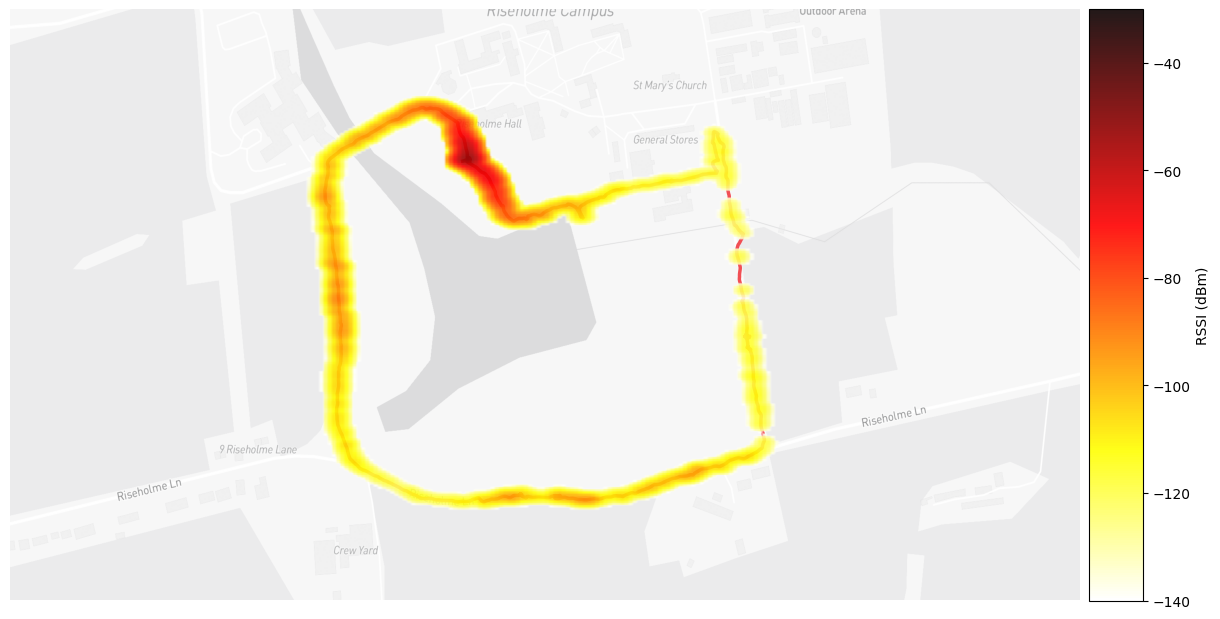

In [299]:
plotter.plot_gpx_on_map(
    path_to_gpx=GPX_FILE_PATH
)